# Unlocking Church Growth: Data Insights from the National Congregations Study
# Worship Service Analysis

## Objective
In this segment of the analysis we specifically explore the features associated to the Worship Service of the congregation and how they may impact an attendance change. The features included are:<br>
 - Services: The number of services per week
 - Lenght: length of service in minutes
 - Sermon: was a sermon involved in the worship service?
 - Sermon Time: length of the sermon in minutes
 - Podium: did the speaker come down off the altar, podium, chancel, or stage during hte sermon?
 - Unique Speakers: how many unique speakers were there?
 - Greetings: Was time allocated for greetings, handshaking, etc. during the service?
 - Kids: was a part of the service specifically for children?
 - Teens: were any speaking, singing, or performing parts specifically for teens in the service?
 - Robe: did the clergy leader wear a robe?
 - Applause: was there applause during any point of the service?
 - Laughing: was laughing invoked during the service?
 - Bulletin: was a program, bulletin, or other written order of service distributed?
 - Streamed: was the service broadcast or streamed live?
 - Smartphone: were people offered the opportunity to use their smartphones to participate in some way?
 - Congregational Reading: did hte congregation speak, read, or recite something together at any point?
 - Offering: was a monetary offering collected during the service?
 - Social Time: how long did people mingle informally before and after the service in minutes?

## Data Preparation

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from scipy.stats import spearmanr, pearsonr, chi2_contingency, fisher_exact
from scipy.stats.contingency import relative_risk
from scipy.stats.contingency import odds_ratio
from scipy.stats import f_oneway  # Inferential Analysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE # Rancom Forest oversampling
import itertools
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import pointbiserialr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer


# Import DictionaryCollection class from Dictionaries.py
    # Download the file from GitHub
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/notebook/dictionaries.py'
response = requests.get(url)

    # Save the file locally
with open('dictionaries.py', 'wb') as file:
    file.write(response.content)
from dictionaries import dictionaryCollection

In [2]:
# Load Data
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/dataset/dataset.csv'
data = pd.read_csv(url)

In [3]:
# Initialize DictionaryCollection instance
dict_collection = dictionaryCollection()

# Replace numerical values column with string values from dictionaries
data = dict_collection.replace_numeric_values(data)

In [4]:
def set_seaborn_style(font_family, background_color, grid_color, text_color):
    sns.set_style({
        "axes.facecolor": background_color,
        "figure.facecolor": background_color,

        "grid.color": grid_color,
        "axes.edgecolor": grid_color,
        "axes.grid": True,
        "axes.axisbelow": True,
        
        "axes.labelcolor": text_color,
        "text.color": text_color,
        "font.family": font_family,
        "xtick.color": text_color,
        "ytick.color": text_color,

        "xtick.bottom": False,
        "xtick.top": False,
        "ytick.left": False,
        "ytick.right": False,

        "axes.spines.left": False,
        "axes.spines.bottom": True,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

background_color = "#006064"
grid_color = "#cccccc"
bar_color = "#009688"
text_color = "#ffffff"
font_family = "Arial"

set_seaborn_style(font_family, background_color, grid_color, text_color)

### Data Transformations

In [5]:
# Create new features based on conditions
data['change_category'] = data['CHANGE'].apply(
    lambda x: "Increase" if "Increased" in str(x) else ("Decrease" if "Decreased" in str(x) else ("Same" if "Same" in str(x) else "Same"))
)

# Change column data types
data['DENOM'] = data['DENOM'].astype('category')
data['change_category'] = data['change_category'].astype('category')

### Data Cleaning

In [6]:
# Select specific features
selected_columns = ['DENOM', 'CLSYACS', 'CLSADLT', 'YTHGRP', 'TEENCHOR', 'TEENCAMP', 'TEENVOL', 'POLITICS', 'DISBIBLE', 'BOOKS', 'PARENTS', 'VOTERREG', 'SCIENCE', 'ENVIRON', 'ORGVOLS', 'WORKPROB', 'NEWMEMS', 'TRAIN', 'RACEREL', 'OTHTRAD', 'OWNMONY', 'CONGMONY', 'ASSESS', 'MARRIAGE', 'WOMENGRP', 'MENGRP', 'EXERCISE', 'LGBT', 'change_category']
df_programs = data[selected_columns].copy()

In [7]:
# Drop DENOM
df_programs.drop(['DENOM'], axis=1, inplace=True)

# One-Hot Encoding
categorical_columns = df_programs.select_dtypes(include=['category']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_programs[categorical_columns])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
df_programs_encoded = pd.concat([df_programs, encoded_df], axis=1)
df_programs_encoded = df_programs_encoded.drop(categorical_columns, axis=1)

## Descriptive Analysis

In [8]:
# Basic exploration
df_programs.info()
df_programs.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CLSYACS          1502 non-null   object  
 1   CLSADLT          1503 non-null   object  
 2   YTHGRP           1502 non-null   object  
 3   TEENCHOR         1503 non-null   object  
 4   TEENCAMP         1500 non-null   object  
 5   TEENVOL          1498 non-null   object  
 6   POLITICS         5311 non-null   object  
 7   DISBIBLE         1330 non-null   object  
 8   BOOKS            2729 non-null   object  
 9   PARENTS          2726 non-null   object  
 10  VOTERREG         5297 non-null   object  
 11  SCIENCE          1250 non-null   object  
 12  ENVIRON          2480 non-null   object  
 13  ORGVOLS          1227 non-null   object  
 14  WORKPROB         1228 non-null   object  
 15  NEWMEMS          2732 non-null   object  
 16  TRAIN            4054 non-null   object  


,CLSYACS,CLSADLT,YTHGRP,TEENCHOR,TEENCAMP,TEENVOL,POLITICS,DISBIBLE,BOOKS,PARENTS,...,OTHTRAD,OWNMONY,CONGMONY,ASSESS,MARRIAGE,WOMENGRP,MENGRP,EXERCISE,LGBT,change_category
count,1502,1503,1502,1503,1500,1498,5311,1330,2729,2726,...,5300,3804,2557,5307,1504,1331,1330,2583,1247,5333
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,3
top,False,True,True,False,True,True,False,True,True,True,...,False,False,True,True,True,True,True,False,False,Same
freq,817,1289,1225,785,1220,1202,4579,1278,1458,1679,...,3475,2176,1639,3106,862,1131,1010,1385,917,4383


## Exploratory Data Analysis (EDA)
Correlation Analysis: Use correlation matrices to identify relationships between congregational offerings and attendance.<br>
Visualization: Create visualizations such as histograms, box plots, scatter plots, and heatmaps to explore patterns and trends.

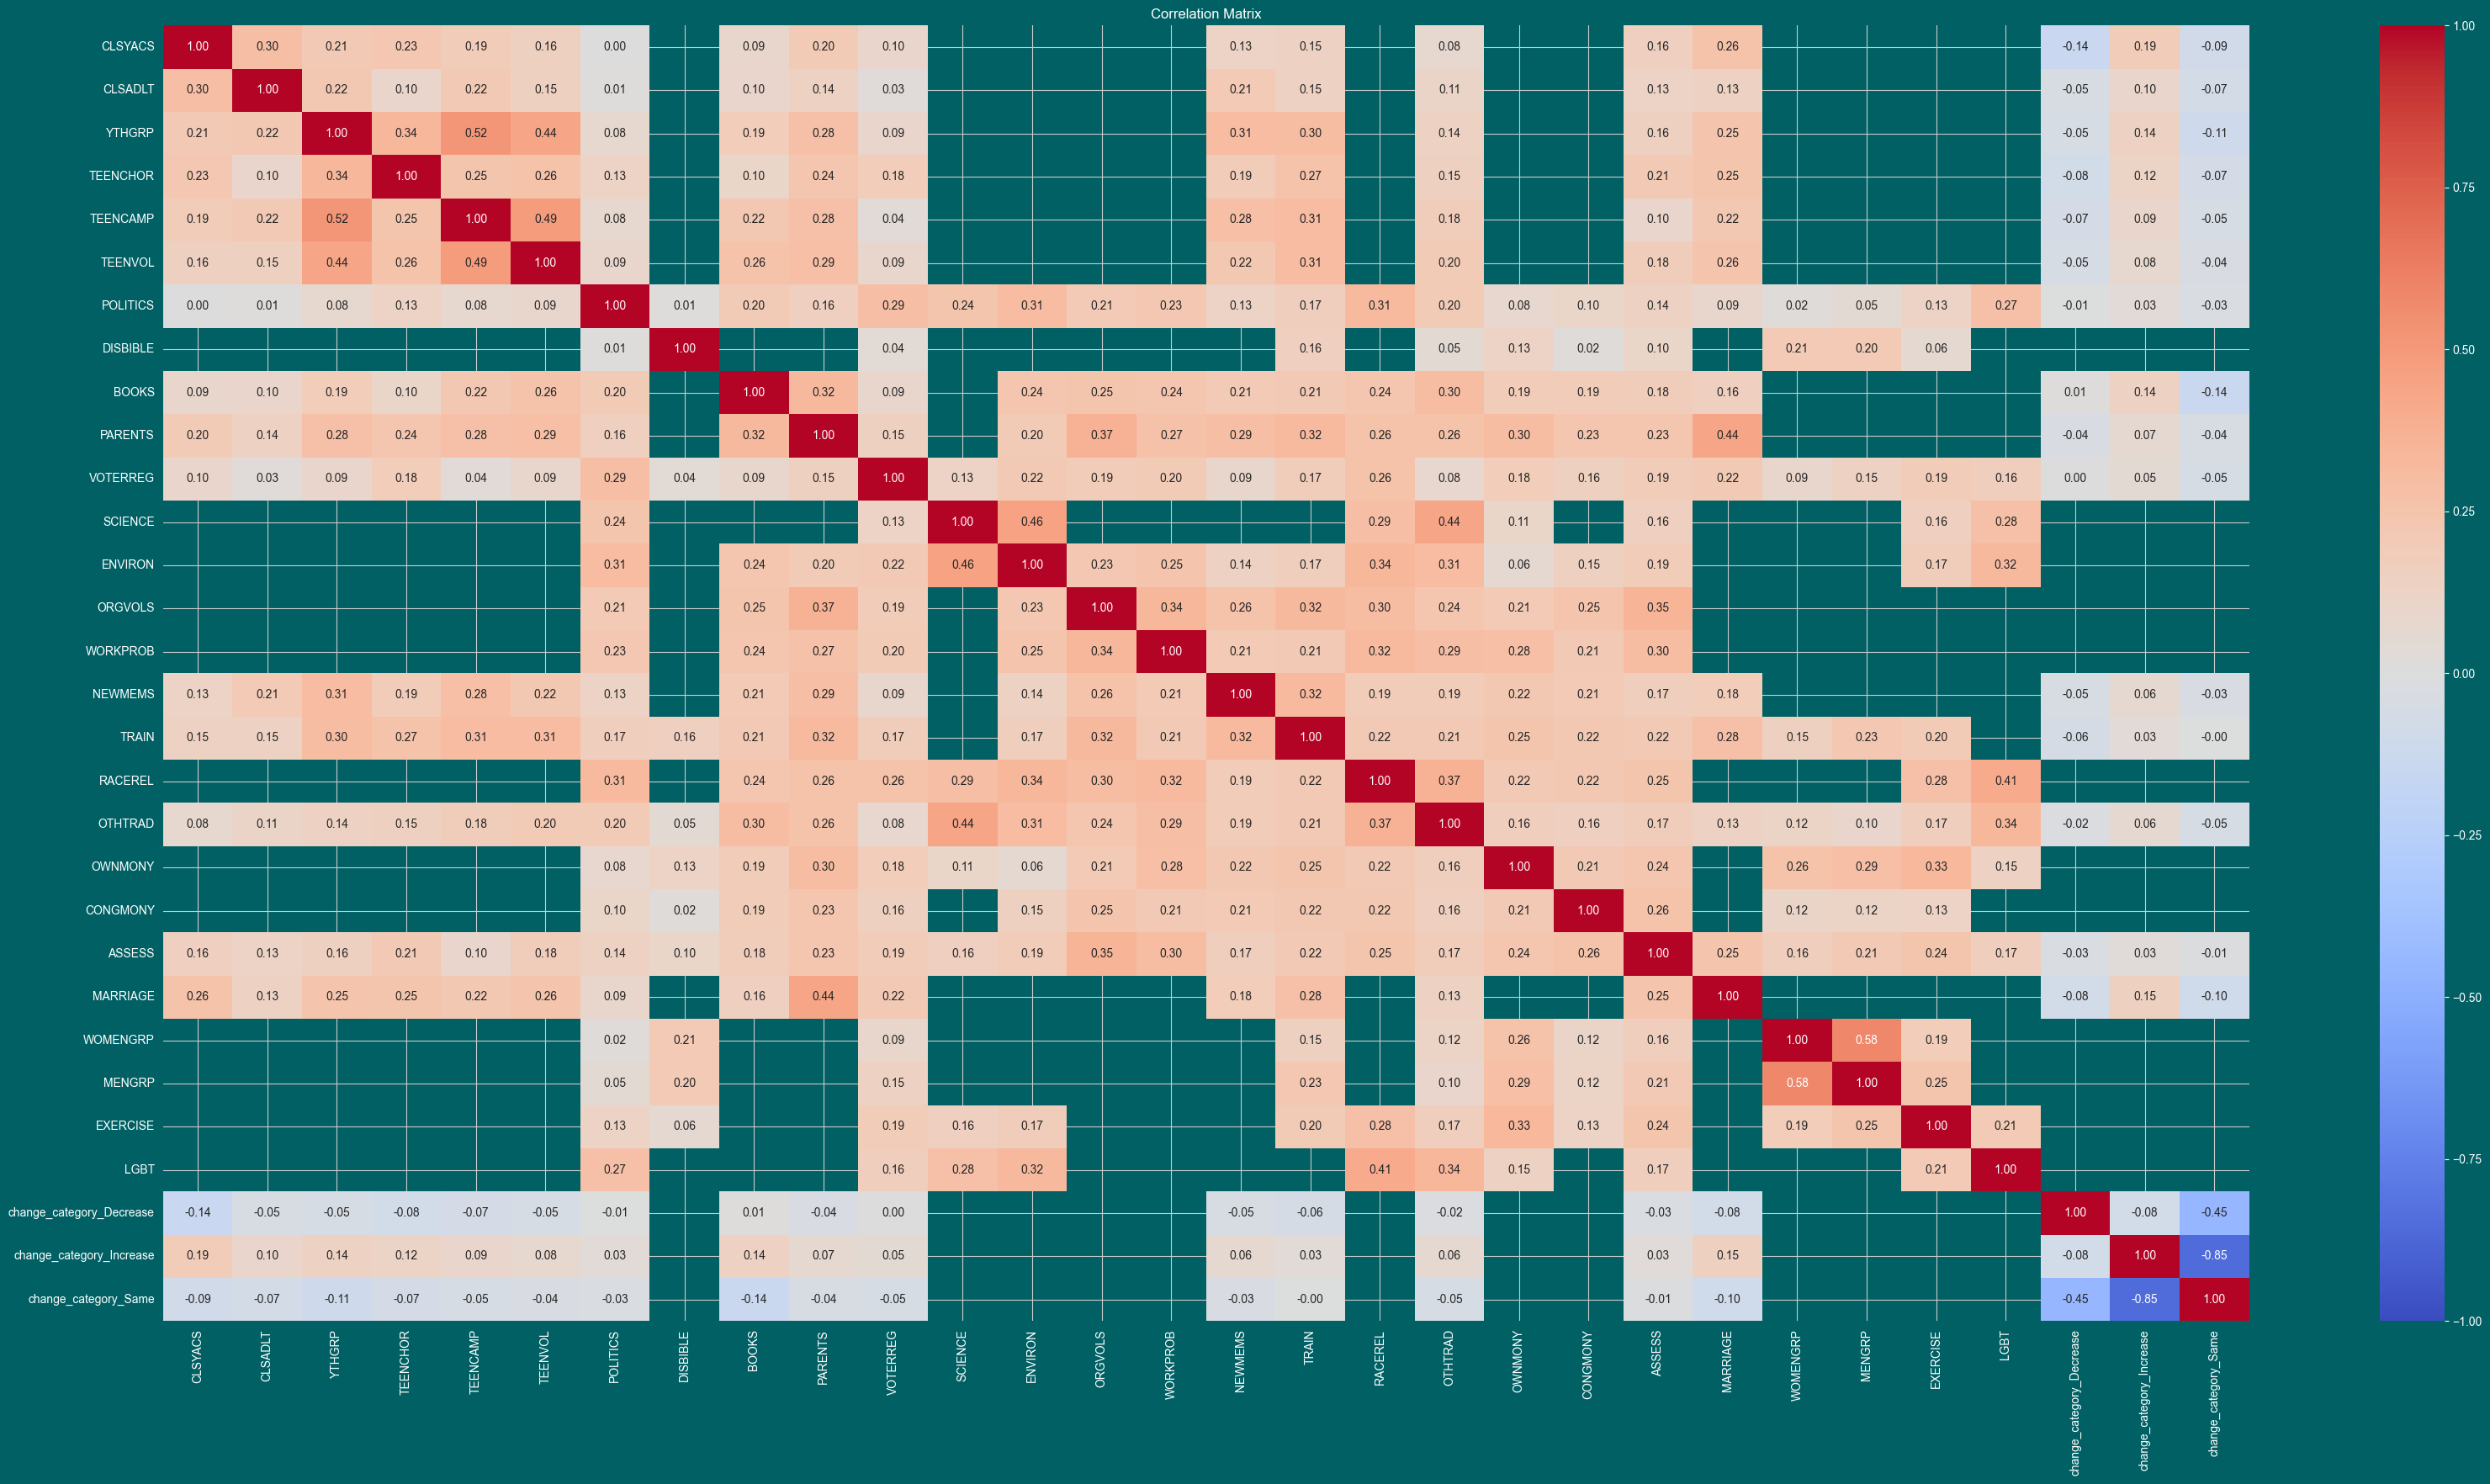

In [9]:
# Perform correlation analysis
correlation_matrix = df_programs_encoded.corr()

plt.figure(figsize=(40,20))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Add plot title and show plot
plt.title('Correlation Matrix')
plt.show()

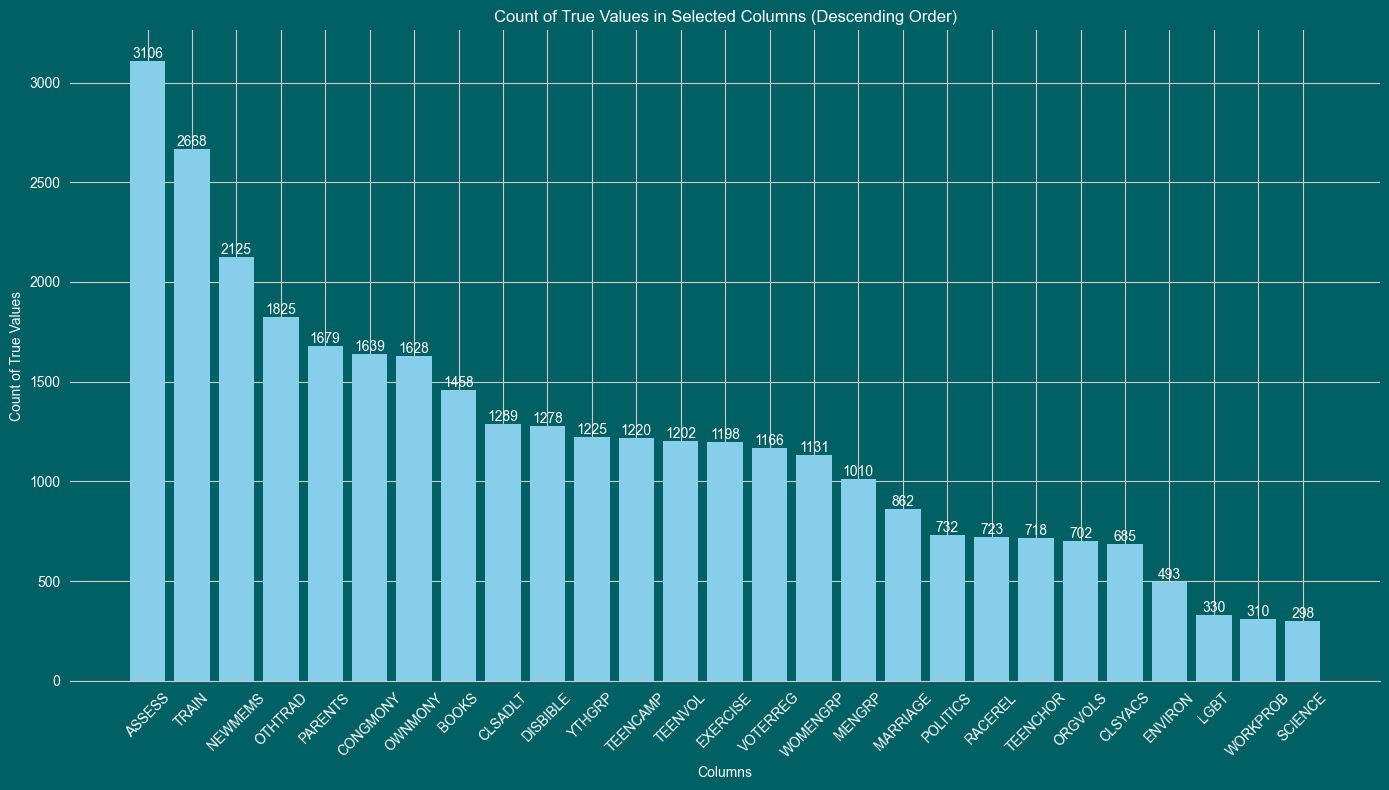

In [10]:
# Specify columns of interest
columns_of_interest = ['CLSYACS', 'CLSADLT', 'YTHGRP', 'TEENCHOR', 'TEENCAMP', 'TEENVOL', 'POLITICS', 'DISBIBLE', 'BOOKS', 'PARENTS', 'VOTERREG', 'SCIENCE', 'ENVIRON', 'ORGVOLS', 'WORKPROB', 'NEWMEMS', 'TRAIN', 'RACEREL', 'OTHTRAD', 'OWNMONY', 'CONGMONY', 'ASSESS', 'MARRIAGE', 'WOMENGRP', 'MENGRP', 'EXERCISE', 'LGBT']

# Count True values for each column
counts = {col: df_programs_encoded[col].sum() for col in columns_of_interest}

# Sort counts in descending order
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

# Plot counts for each column as multiple bars in one graph
plt.figure(figsize=(14, 8))

# Create the bar plot with sorted counts
bars = plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')

# Adding labels and title
plt.xlabel('Columns')
plt.ylabel('Count of True Values')
plt.title('Count of True Values in Selected Columns (Descending Order)')

# Adding data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Inferential Analysis
Hypothesis Testing: Conduct hypothesis tests (e.g., t-tests, ANOVA) to determine if there are statistically significant differences in attendance based on different offerings.

In [11]:
# Chi-Square Test for Independence
results = []
for col in df_programs.select_dtypes(include='category').columns:
    if col != 'change_category':
        contingency_table = pd.crosstab(df_programs[col], df_programs['change_category'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        results.append((col, p))

# Print Results
for feature, p_value in results:
    print(f'Chi-Square Test for {feature} and change_category: p-value = {p_value}')

In [12]:
# ANOVA or Kruskal-Wallis Test
for col in df_programs.select_dtypes(include='number').columns:
    groups = [df_programs[df_programs['change_category'] == cat][col] for cat in df_programs['change_category'].cat.categories]
    f_stat, p_value = f_oneway(*groups)
    print(f'ANOVA Test for {col}: p-value = {p_value}')

## Regression Analysis
Linear Regression: Model the relationship between congregational size (dependent variable) and offerings (independent variables) using linear regression.<br>
Logistic Regression: If the outcome is categorical (e.g., increased attendance vs. no increase), use logistic regression.

## Multivariate Analysis
Multiple Regression: Extend linear regression to include multiple independent variables to account for the effect of various factors simultaneously.<br>
Principal Component Analysis (PCA): Reduce dimensionality and identify key factors contributing to attendance changes.

## Time Series Analysis
Trend Analysis: Examine how congregational size and offerings have changed over time.<br>
Seasonality: Identify seasonal patterns in attendance.

## Predictive Analysis
Machine Learning Models: Implement machine learning models (e.g., decision trees, random forests, gradient boosting) to predict attendance based on congregational offerings.<br>
Model Evaluation: Use cross-validation and performance metrics (e.g., RMSE, AUC) to assess model accuracy.

In [13]:
# Select specific features and target
selected_columns = ['CLSYACS', 'CLSADLT', 'YTHGRP', 'TEENCHOR', 'TEENCAMP', 'TEENVOL', 'BOOKS', 'PARENTS', 'VOTERREG', 'NEWMEMS', 'TRAIN', 'OTHTRAD', 'ASSESS', 'MARRIAGE', 'change_category']
df_programs_rf = data[selected_columns].copy()

In [14]:
df_programs_rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CLSYACS          1502 non-null   object  
 1   CLSADLT          1503 non-null   object  
 2   YTHGRP           1502 non-null   object  
 3   TEENCHOR         1503 non-null   object  
 4   TEENCAMP         1500 non-null   object  
 5   TEENVOL          1498 non-null   object  
 6   BOOKS            2729 non-null   object  
 7   PARENTS          2726 non-null   object  
 8   VOTERREG         5297 non-null   object  
 9   NEWMEMS          2732 non-null   object  
 10  TRAIN            4054 non-null   object  
 11  OTHTRAD          5300 non-null   object  
 12  ASSESS           5307 non-null   object  
 13  MARRIAGE         1504 non-null   object  
 14  change_category  5333 non-null   category
dtypes: category(1), object(14)
memory usage: 588.8+ KB


In [15]:
# Count values in each column
value_counts = {col: df_programs_rf[col].value_counts() for col in df_programs_rf.columns}

# Print value counts for each column
for col, counts in value_counts.items():
    print(f"Value counts for column '{col}':")
    print(counts)
    print()  # Blank line for readability

Value counts for column 'CLSYACS':
CLSYACS
False    817
True     685
Name: count, dtype: int64

Value counts for column 'CLSADLT':
CLSADLT
True     1289
False     214
Name: count, dtype: int64

Value counts for column 'YTHGRP':
YTHGRP
True     1225
False     277
Name: count, dtype: int64

Value counts for column 'TEENCHOR':
TEENCHOR
False    785
True     718
Name: count, dtype: int64

Value counts for column 'TEENCAMP':
TEENCAMP
True     1220
False     280
Name: count, dtype: int64

Value counts for column 'TEENVOL':
TEENVOL
True     1202
False     296
Name: count, dtype: int64

Value counts for column 'BOOKS':
BOOKS
True     1458
False    1271
Name: count, dtype: int64

Value counts for column 'PARENTS':
PARENTS
True     1679
False    1047
Name: count, dtype: int64

Value counts for column 'VOTERREG':
VOTERREG
False    4131
True     1166
Name: count, dtype: int64

Value counts for column 'NEWMEMS':
NEWMEMS
True     2125
False     607
Name: count, dtype: int64

Value counts for column 

C:\Users\natha\AppData\Local\Temp\ipykernel_7440\1492039507.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_programs_rf[col] = df_programs_rf[col].fillna(False)


Accuracy of the Random Forest model: 0.8287


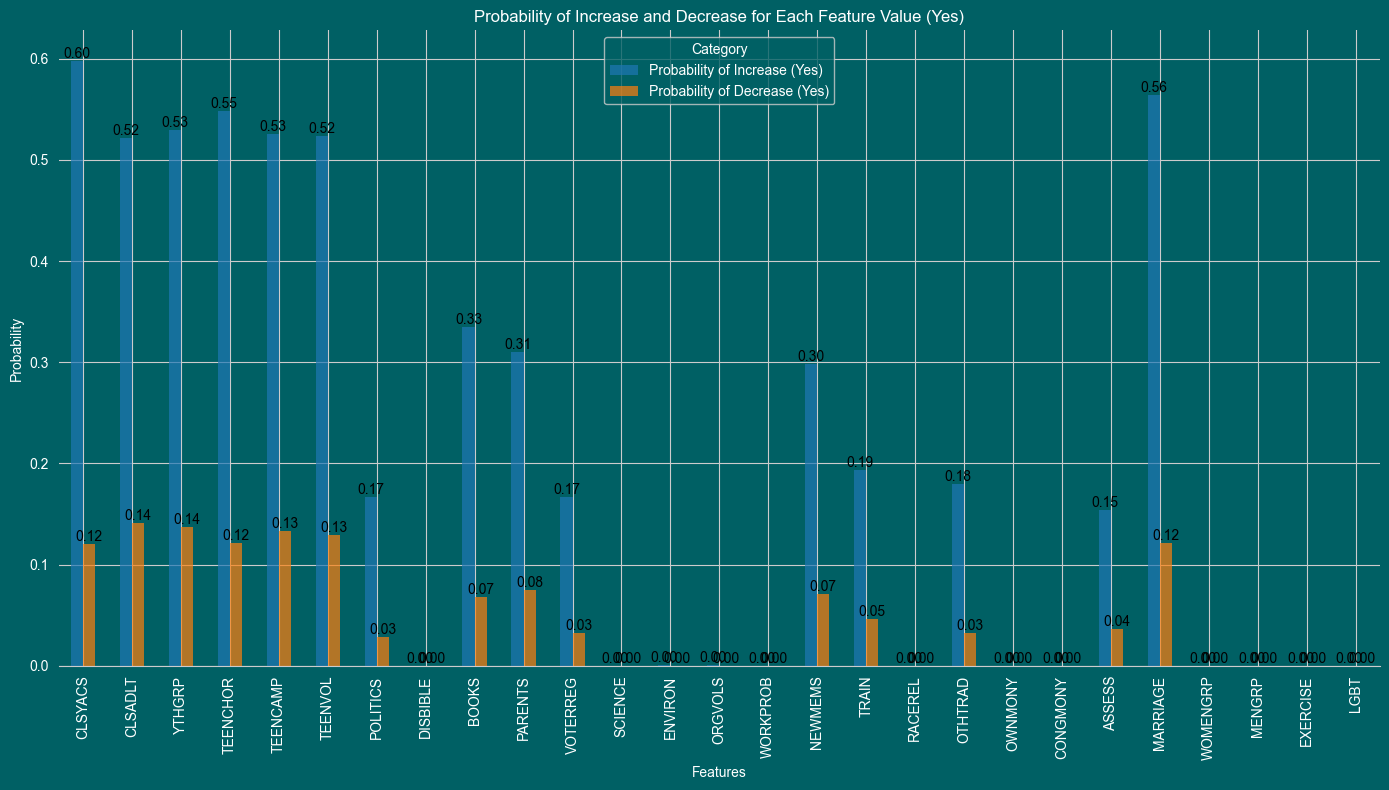

In [17]:
# Random Forest

# Select specific features
selected_columns = ['CLSYACS', 'CLSADLT', 'YTHGRP', 'TEENCHOR', 'TEENCAMP', 'TEENVOL', 'POLITICS', 'DISBIBLE', 'BOOKS', 'PARENTS', 'VOTERREG', 'SCIENCE', 'ENVIRON', 'ORGVOLS', 'WORKPROB', 'NEWMEMS', 'TRAIN', 'RACEREL', 'OTHTRAD', 'OWNMONY', 'CONGMONY', 'ASSESS', 'MARRIAGE', 'WOMENGRP', 'MENGRP', 'EXERCISE', 'LGBT', 'change_category']
df_programs_rf = data[selected_columns].copy()

# Replace NaN or missing values with False, except for the categorical column 'change_category'
for col in df_programs_rf.columns:
    if col != 'change_category':  # Exclude the categorical column
        df_programs_rf[col] = df_programs_rf[col].fillna(False)

# Prepare features and target
X = df_programs_rf.drop('change_category', axis=1)
y = df_programs_rf['change_category']

# Convert Boolean features to int
X = X.astype(int)

# Drop rows with missing values (if any)
X = X.dropna()
y = y[X.index]  # Keep y aligned with X after dropping rows

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Random Forest model: {accuracy:.4f}")

# Predict probabilities
probs = rf_model.predict_proba(X_test)

# Convert probabilities to DataFrame
probs_df = pd.DataFrame(probs, columns=rf_model.classes_, index=X_test.index)

# Calculate mean probabilities for 'Increase' and 'Decrease'
feature_probs = {}

for feature in X.columns:
    feature_probs[feature] = {
        'Increase': probs_df.loc[X_test[feature] == 1, 'Increase'].mean(),
        'Decrease': probs_df.loc[X_test[feature] == 1, 'Decrease'].mean()
    }

# Convert to DataFrame for plotting
feature_probs_df = pd.DataFrame(feature_probs).T
feature_probs_df.columns = ['Probability of Increase (Yes)', 'Probability of Decrease (Yes)']

# Plot
ax = feature_probs_df.plot(kind='bar', figsize=(14, 8), alpha=0.7)
plt.title('Probability of Increase and Decrease for Each Feature Value (Yes)')
plt.xlabel('Features')
plt.ylabel('Probability')
plt.legend(title='Category')
plt.tight_layout()

# Adding data labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10, color='black')

plt.show()

## Causal Analysis
Causal Inference: Use methods like propensity score matching or instrumental variables to identify causal relationships between offerings and attendance.

## Recommendations
Actionable Insights: Provide recommendations based on the analysis, highlighting which factors most significantly influence attendance.<br>
Scenario Analysis: Simulate different scenarios to predict the impact of changes in offerings on attendance.